# intro

The purpose of this notebook create the J terms for a single map grid cell at the surface, show the residuals and look at the comparable contributions of different terms

# packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%run /home/mmurakami/crios_backups/ASTE_270/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



# read grid and files also the mask

In [4]:
# define basin we want
iB = 6   # see mskBasin if you want for later; maybe we should write this to file
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [5]:
iB = 6    # read from BarentsSea
    
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


# plot the bathymetry of the basin

In [6]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('RdBu_r',31).copy()
cmaps = plt.get_cmap('rainbow',31).copy()
cmap.set_under(color='white')
cmap_bath = plt.get_cmap('Blues',31).copy()

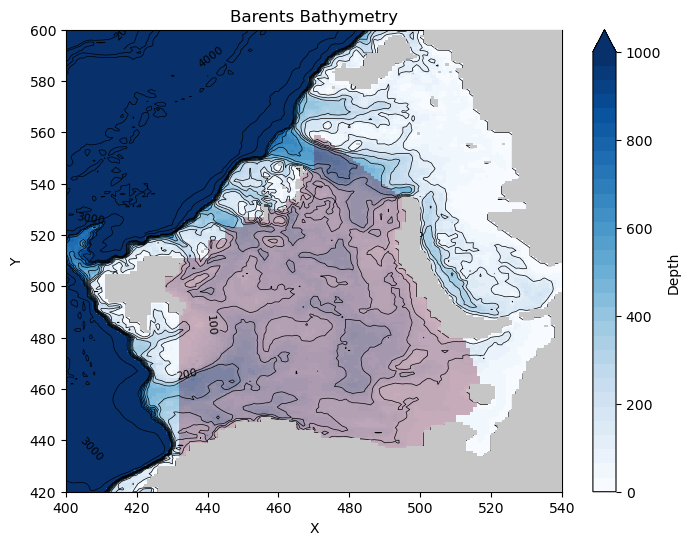

In [7]:
# land mask
landmsk = np.full(mygrid['hFacC'].shape, np.nan)
landmsk[np.isnan(mygrid['hFacC'])] = 1
landmsk[~np.isnan(mygrid['hFacC'])] = np.nan
landmsk = get_aste_tracer(landmsk,nfx,nfy)

# mesh
x = np.arange(0,540,1)
y = np.arange(0,900,1)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(8, 6))
# Levels every 100 meters from 0 to 1000 and every 1000 meters from 1000 upwards
levels = np.concatenate([np.arange(0, 1000, 100), np.arange(1000, 6000, 1000)])
pcolor_plot = plt.pcolor(X, Y, get_aste_tracer(DD,nfx,nfy)[0], shading='auto',vmax=1000,cmap=cmap_bath)
# Add colorbar
cbar = plt.colorbar(pcolor_plot, label='Depth',extend="max")
# Add contour lines
contour_lines = plt.contour(X, Y, get_aste_tracer(DD,nfx,nfy)[0], levels=levels, colors='black', linewidths=0.5)
plt.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
# Add labels to the contour lines
plt.clabel(contour_lines, inline=True, fontsize=8)
# Add title and axis labels
plt.title('Barents Bathymetry')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(400,540)
plt.ylim(420,600)

plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0],alpha=.3,cmap="RdBu")


# plt.savefig(path + "Barents_bathymetry.png",dpi=300)

## Get the timesteps

In [195]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2014"] = np.arange(9,11,1)
# times["2014"] = np.arange(9,11,1)
# times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

In [196]:
dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

In [197]:
# ocean and ice
AB_gT=0
AB_gS=0

# create the salt budget
### salt tendency

In [198]:
# read thetadr
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])


SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisSALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisSALTDR = thisSALTDR.reshape(nz,ny,nx)
    SALTDR[i] = thisSALTDR

SALTDR =  (SALTDR[1, :, :,:] - SALTDR[0, :,:, :]) / dt    # PSU.m/s

In [199]:
tmptend = myparms['rhoconst'] * (SALTDR - AB_gS) * mk3D_mod(RAC,SALTDR)    # kg/m^3 * PSU.m/s * m^2 = g/s
budgO = {}
budgO['saltfluxes'] = {}
budgI = {}
budgI['saltfluxes'] = {}
budgOI = {}

# ocean

budgO['saltfluxes']['tend'] = tmptend
budgO['salttend'] = np.nansum(tmptend,axis=0)

### salt h conv

In [200]:
# read adv and dfe
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

tmpUo = myparms['rhoconst'] * (ADVx_SLT + DFxE_SLT)
tmpVo = myparms['rhoconst'] * (ADVy_SLT + DFyE_SLT)

# reshape and get the faces
tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['saltfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['salthconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo,axis=0),np.nansum(tmpVo,axis=0))

In [201]:
# also do hconv for ADV and DF
tmpUo = get_aste_faces(ADVx_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

tmpUo = get_aste_faces(DFxE_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

In [202]:
# read the vars
file_name = "budg2d_hflux_set1"
meta_budg2d_hflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_hflux_set1["fldList"])
varnames = np.array(["ADVxHEFF","ADVyHEFF","DFxEHEFF","DFyEHEFF"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVyHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
ADVxHEFF = ADVxHEFF.reshape(ny,nx)
ADVyHEFF = ADVxHEFF.reshape(ny,nx)
DFxEHEFF = DFxEHEFF.reshape(ny,nx)
DFyEHEFF = DFyEHEFF.reshape(ny,nx)
    
if myparms['seaice_variable_salinity_flag'] == 0:
    SIsal0 = myparms['SIsal0']

tmpUi = SIsal0 * myparms['rhoi'] * (DFxEHEFF + ADVxHEFF)
tmpVi = SIsal0 * myparms['rhoi'] * (DFyEHEFF + ADVyHEFF)
tmpUi = get_aste_faces(tmpUi,nfx,nfy)              
tmpVi = get_aste_faces(tmpVi,nfx,nfy)

budgI['salthconv'] = calc_UV_conv_mod(nfx,nfy,tmpUi, tmpVi)
budgOI['salthconv'] = (budgO['salthconv'] + budgI['salthconv'])

### salt v convergence

In [203]:
# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
SFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPflx = oceSPflx.reshape(ny,nx)
SFLUX = SFLUX.reshape(ny,nx)

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS","SRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)
SRELAX = SRELAX.reshape(ny,nx)

In [204]:
# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPtnd,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPtnd = oceSPtnd.reshape(nz,ny,nx)
KPPg_SLT = KPPg_SLT.reshape(nz,ny,nx)


# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT","DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)
DFrE_SLT = DFrE_SLT.reshape(nz,ny,nx)
DFrI_SLT = DFrI_SLT.reshape(nz,ny,nx)

In [205]:
if myparms["useRFWF"]==0 or myparms['useNLFS']==0:
    print('do nothing')
else:
    oceSflux = 0 * oceSflux

if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WSLTMASS=0*WSLTMASS

budgO['saltzconv'] = SFLUX + oceSPflx                  # W/m^2
zconv_top_salt = (SFLUX + oceSPflx) * RAC               # g/s
budgI['saltzconv'] = -budgO['saltzconv'] + SRELAX

if myparms['useNLFS']==0:
    budgO['saltzconv'] = budgO['saltzconv'] - myparms['rhoconst']*WSLTMASS

if myparms['useRFWF']==0 or myparms['useNLFS']==0:
    budgI['saltzconv']=-oceSflux

In [206]:
nr = mygrid['RC'].shape[0]
# break trWtop down into smaller terms
trWtopADV = -(ADVr_SLT)*myparms['rhoconst']           # g/s
trWtopDF = -(DFrE_SLT+DFrI_SLT)*myparms['rhoconst']   # g/s
trWtopKPP = -(KPPg_SLT)*myparms['rhoconst']           # g/s
trWtop = trWtopADV + trWtopDF + trWtopKPP             # g/s 

print(trWtop.shape)
sptop = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)        # we include this in our zconv_top term
sptop = sptop * RAC3        # g/s

trWtop[1:,:,:] = trWtop[1:,:,:] + sptop[:-1,:,:]
trWtop[0,:,:] = budgO['saltzconv'] * RAC    # g/s top layer is surface flux

trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:] = trWtop[1:,:,:]
trWbot[-1,:,:] = 0

budgO['saltfluxes']['trWtop'] = trWtop     # g/s
budgO['saltfluxes']['trWbot'] = trWbot     # g/s

budgI['saltfluxes']['trWtop'] = -RAC*0
budgI['saltfluxes']['trWbot'] = budgO['saltfluxes']['trWtop'][0,:,:]  # surface because ice

budgO['saltfluxes']['zconv'] = budgO['saltfluxes']['trWtop'] - budgO['saltfluxes']['trWbot']
budgO['saltzconv'] = RAC * budgO['saltzconv']   # g/s
budgI['saltzconv'] = RAC * budgI['saltzconv']   # g/s
budgOI['saltzconv'] = budgO['saltzconv'] + budgI['saltzconv']

(50, 1350, 270)


In [207]:
# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Sconv = budgO['saltfluxes']['ADV_hconv'] + tmpadv
budgO['saltfluxes']['ADV_Sconv'] = Sconv             # g/s, this is the advective arrow of S for a cell

In [208]:
# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfSconv = budgO['saltfluxes']['DF_hconv'] + tmpdf
budgO['saltfluxes']['DF_Sconv'] = dfSconv             # g/s, this is the diffusive arrow of T for a cell

In [209]:
tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['saltfluxes']['KPP_Sconv'] = tmpkpp        # no horizontal component for this

### show salt is budgeted

In [210]:
# pick one point from face 3 and one point from face 1
pt = np.array([[10,500,4],       # this is organized as x,y,z
               [220,445,10]])

pt = np.array([[10,500,4],       # this is organized as x,y,z
               [100,600,10]])

# 0 540 50
pt = np.array([[50,540,4],       # this is organized as x,y,z
               [100,600,10]])

y,x = 540,50

pt = np.array([[50,540,0],
               [25,500,0]])      # first is an extreme point, second is a more "normal" or midrange point for 03/2014

In [211]:
# Data variables (as given in your initial code)
a = budgO['saltfluxes']['tend']
b = budgO['saltfluxes']['ADV_Sconv']
c = budgO['saltfluxes']['DF_Sconv']
d = budgO['saltfluxes']['KPP_Sconv']
e = zconv_top_salt.reshape(1,ny,nx)                 # only at surface, is the surface forcing  ((SFLUX + oceSPflx) * RAC) in g/s
f = sptop                                            # oceSPtnd contribution from the ice

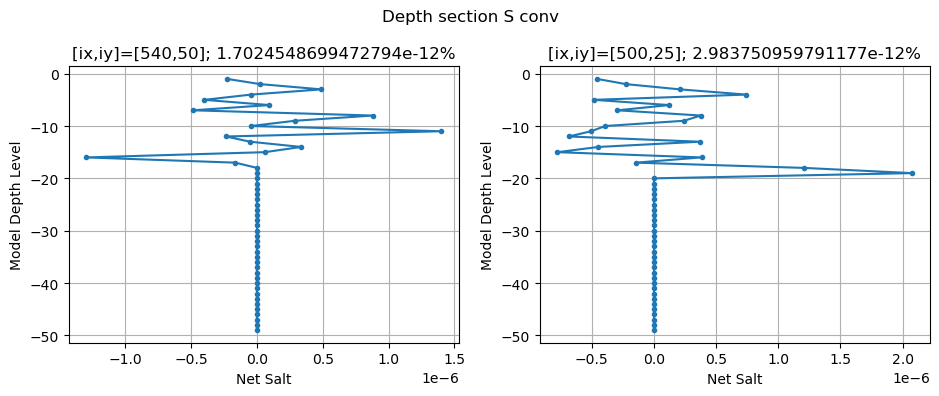

In [212]:
# also show the convergence at depth - I will make this a 1 by 2 plot so I can look at things easier

plt.figure(figsize=(9.5, 4))

aa = np.zeros((nz, 2))
plt.suptitle("Depth section S conv")


n = 1
ix, iy, k = pt[n-1]
aa[:, n-1] = a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix]
aa[1:, n-1] += (f[1:,iy,ix] - f[:-1,iy,ix])                                  # from the oceSPflx and oceSPtnd
aa[0, n-1] += f[0,iy,ix]
aa[0, n-1] -= zconv_top_salt[iy, ix]
plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Salt")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['saltfluxes']['zconv'][:,iy, ix]))}%")

n = 2
ix, iy, k = pt[n-1]
aa[:, n-1] = a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix]
aa[1:, n-1] += (f[1:,iy,ix] - f[:-1,iy,ix])                                  # from the oceSPflx and oceSPtnd
aa[0, n-1] += f[0,iy,ix]
aa[0, n-1] -= zconv_top_salt[iy, ix]

plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Salt")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['saltfluxes']['zconv'][:,iy, ix]))}%")
    
        
plt.tight_layout()
plt.show()

# now do the heat budget
### start with the tendency

In [213]:
# read thetadr
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisTHETADR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisTHETADR = thisTHETADR.reshape(nz,ny,nx)
    THETADR[i] = thisTHETADR

THETADR =  (THETADR[1, :, :,:] - THETADR[0, :,:, :]) / dt    # degC.m/s

In [214]:
tmptend=myparms['rcp']*(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)   # J/m^3.degC * degC.m/s * m^2 = J/s
budgO['heatfluxes'] = {}
budgI['heatfluxes'] = {}

budgO['heatfluxes']['tend'] = tmptend     # J/s

budgO['heattend'] = np.nansum(tmptend,axis=0)

### do h convergence

In [215]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","DFxE_TH","DFyE_TH","UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
UVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[4])
VVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[5])  # m/s

# reshape the UVELMASS and VVELMASS to look at these
UVELMASS = UVELMASS.reshape(nz,ny,nx)
VVELMASS = VVELMASS.reshape(nz,ny,nx)

tmpUo = myparms['rcp'] * (ADVx_TH + DFxE_TH)
tmpVo = myparms['rcp'] * (ADVy_TH + DFyE_TH)

tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)

# get the faces so we can do convergence
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['heatfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['heathconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo, axis=0),np.nansum(tmpVo,axis=0))

In [216]:
# add the budgeting for ADV and DF
tmpUo = get_aste_faces(ADVx_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['heatfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp'] #J/s

tmpUo = get_aste_faces(DFxE_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['heatfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp'] #J/s

### do the vertical convergence

In [217]:
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["TFLUX","oceQsw","SItflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
TFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
oceQsw,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SItflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TFLUX = TFLUX.reshape(ny,nx)
oceQsw = oceQsw.reshape(ny,nx)
SItflux = SItflux.reshape(ny,nx)

# note: the following works provided that the first 3 terms are definitely there
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceQnet","WTHMASS","SIaaflux","TRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceQnet,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WTHMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SIaaflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
oceQnet = oceQnet.reshape(ny,nx)
WTHMASS = WTHMASS.reshape(ny,nx)
SIaaflux = SIaaflux.reshape(ny,nx)
TRELAX = TRELAX.reshape(ny,nx)

# note: will not work if these are defined, fix for future steps
varnames = np.array(["TRELAX","SIabflux","SIacflux","SIeprflx","SIfldflx"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

# if len(recs) == 0:
SIabflux = np.zeros((ny, nx))
SIacflux = np.zeros((ny, nx))
SIeprflx = np.zeros((ny, nx))
SIfldflx = np.zeros((ny, nx))

In [218]:
if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WTHMASS=0*WTHMASS

In [219]:
geothFlux = 0

if myparms['SaltPlumeHeatFlux']:
    print(1)
else:
    SPforcT1=0*np.ones((ny,nx))
    oceEPtnd=0*np.ones((nz,ny,nx))

In [220]:
# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["KPPg_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
KPPg_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_TH = KPPg_TH.reshape(nz,ny,nx)

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_TH","DFrE_TH","DFrI_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)
DFrE_TH = DFrE_TH.reshape(nz,ny,nx)
DFrI_TH = DFrI_TH.reshape(nz,ny,nx)

In [221]:
budgO['heatzconv']=TFLUX+geothFlux+SPforcT1                           # W/m^2 = J/m^2/s
zconv_top_heat = TFLUX  * RAC     # W/m^2 * m^2 = J/s
budgI['heatzconv']=-(SItflux+TFLUX-TRELAX+SPforcT1)

if myparms['useNLFS']==0:
    print(1)
    budgO['heatzconv']=budgO['heatzconv']-myparms['rcp']*WTHMASS[:,:]     # degC.m/s * J/m^3degC = J/m^2.s

budgI['heatzconv']=budgI['heatzconv']-SIabflux+SIacflux+SIeprflx
if(myparms['SEAICEheatConsFix']==0):
    print(2)
    budgI['heatzconv']=budgI['heatzconv']+SIaaflux

2


In [222]:
nr = mygrid['RC'].shape[0]
trWtopADV = -(ADVr_TH) * myparms['rcp']         # J/s
trWtopDF = -(DFrE_TH+DFrI_TH) * myparms['rcp']  # J/s
trWtopKPP = -(KPPg_TH) * myparms['rcp']         # J/s
trWtop = trWtopADV + trWtopDF + trWtopKPP       # J/s
dd = mygrid['RF'][:-1]
swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
swfrac[dd < -200] = 0
swtop=mk3D_mod(swfrac,trWtop)*mk3D_mod(RAC*oceQsw,trWtop)   # J/s
mskC=mygrid['mskC']
swtop[np.isnan(mskC)]=0
trWtop=trWtop+swtop  # 323
    
trWtop[0,:,:]=budgO['heatzconv']*RAC
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:]=trWtop[1:,:,:]

budgO["heatfluxes"]["trWtop"] = trWtop
budgO["heatfluxes"]["trWbot"] = trWbot

In [223]:
budgI["heatfluxes"]["trWtop"] = -RAC * (budgI["heatzconv"] + budgO["heatzconv"])
budgI["heatfluxes"]["trWbot"] = -RAC * budgO["heatzconv"]
budgO['heatfluxes']['zconv']=budgO['heatfluxes']['trWtop']-budgO['heatfluxes']['trWbot']

budgO['heatzconv'] = RAC*budgO['heatzconv']  # J/s
budgI['heatzconv']=RAC*budgI['heatzconv']    # J/s
budgOI['heatzconv']=budgO['heatzconv']+budgI['heatzconv']

In [224]:
# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Tconv = budgO['heatfluxes']['ADV_hconv'] + tmpadv
budgO['heatfluxes']['ADV_Tconv'] = Tconv      # J/s, this is the advective arrow of T for a cell

In [225]:
# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfTconv = budgO['heatfluxes']['DF_hconv'] + tmpdf
budgO['heatfluxes']['DF_Tconv'] = dfTconv      # J/s, this is the diffusive arrow of T for a cell

In [226]:
tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['heatfluxes']['KPP_Tconv'] = tmpkpp        # no horizontal component for this

### Show that this is budgeted

In [227]:
# now we can plot these the same way as we did for salt
# Data variables (as given in your initial code)
a = budgO['heatfluxes']['tend']
b = budgO['heatfluxes']['ADV_Tconv']
c = budgO['heatfluxes']['DF_Tconv']
d = budgO['heatfluxes']['KPP_Tconv']
e = zconv_top_heat.reshape(1,ny,nx)                 # NOTE - this is only at the surface
f = swtop

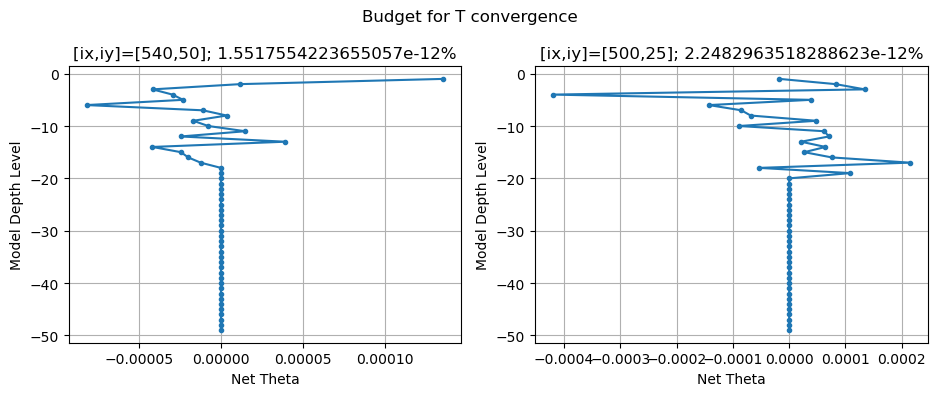

In [228]:
# show the convergence of heat at depth - I will make this a 1 by 2 plot so I can look at things easier
plt.figure(figsize=(9.5, 4))

aa = np.zeros((nz, 2))
plt.suptitle("Budget for T convergence")

n = 1
ix, iy, k = pt[n-1]
aa[:, n-1] = (a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix])
aa[1:-1, n-1] += (f[2:,iy,ix] - f[1:-1,iy,ix])    # for swtop we want the difference between the top and bottom
aa[0, n-1] += f[1,iy,ix]
aa[0, n-1] -= zconv_top_heat[iy, ix]      # subtract the TFLUX at the surface only
plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Theta")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['heatfluxes']['zconv'][:,iy, ix]))}%")

n = 2
ix, iy, k = pt[n-1]
aa[:, n-1] = a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix]
aa[1:-1, n-1] += (f[2:,iy,ix] - f[1:-1,iy,ix])
aa[0, n-1] += f[1,iy,ix]
aa[0, n-1] -= zconv_top_heat[iy, ix]                   # this is because we already included the TFLUX
plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Theta")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['heatfluxes']['zconv'][:,iy, ix]))}%")
    
        
plt.tight_layout()
plt.show()

# get volume and TS values from bins

In [229]:
ffac = 1e-6

In [230]:
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    ETAN = np.reshape(ETAN,(ny,nx))

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC)     # volume, m * m^2  = m^3

    vol[t,:,:,:] = tmpvol * np.tile(mymsk, (nz, 1, 1))

print(vol.shape)

volume allocation shape (2, 50, 1350, 270)
(2, 50, 1350, 270)


In [231]:
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx)
SALT = SALT.reshape(nz,ny,nx)

In [232]:
# create the bins of TS data
# try new T bins where different sizes
refined_section = np.linspace(-3,8,93)
coarse_section = np.linspace(8,15,21,endpoint=False)
binsTH_edges = np.concatenate((refined_section,coarse_section[1:]))
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

# do bi-sectional form for S
coarse_section = np.linspace(0, 28, 30, endpoint=False)
refined_section = np.linspace(28, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)


# create the binned values for theta and salt
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(THETA,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(SALT,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [233]:
maskArc = mskBasin * mymsk

binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

idxs = np.where(maskArc == iB)
npoints = len(idxs[0])
# doing some reshaping here so that we can plot more easily
# mesh = create_TS_mesh(tsstr[:-1],nS,nT,npoints,binned_salinity.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),vol,idxs,dT,dS)
# print(mesh.shape)

# if we want to do just the surface of the basin:
# surf_vol = vol.copy()
# surf_vol[:,1:,:,:] = np.nan
mesh = create_TS_mesh(tsstr[:-1],nS,nT,npoints,binned_salinity.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),vol,idxs,dT,dS)

In [234]:
# sum the volume from the points in dimension 2
vol_mesh = np.nansum(mesh[0],axis=2)

In [235]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

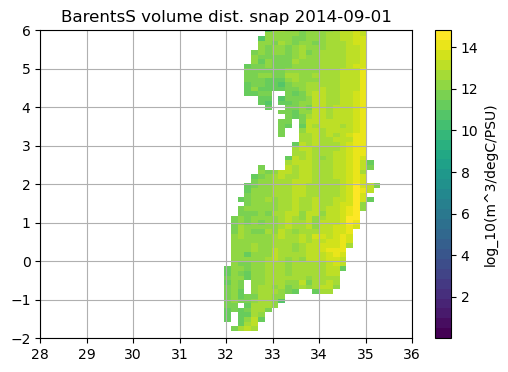

In [236]:
# just plot volume to start ( I am scared I messed something up )
# remake the previous figure with scaled arrows
fig = plt.figure(figsize=(6,4))
sfact = 6   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = 0
U = .25

ax1 = plt.subplot(111)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
# U1, V1 = -G_S_vec_m1,G_T_vec_m1/16
# q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=2e0)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title(strb[iB] + " volume dist. snap " + datetimes[0].strftime("%Y-%m-%d"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2,6)
ax1.grid()
# ax1.quiverkey(q1,X=0.1,Y=0.9,U = U,label=str(U) + " Sv")

# plt.savefig(path + "BarentsS_volume_March2014.png",dpi=300)

In [237]:
# Initialize the mask with NaN values
mask = np.full((nz, ny, nx), np.nan)

# Use broadcasting to set the values within the specified y, x indices to 1
# Assuming z should span the entire range from 0 to nz-1
# for a patch
z = np.arange(nz)[:, None, None]  # Create a 3D array for z
x = np.arange(15,35,1)
y = np.arange(490,510,1)

# for the surface ocean
# x = idxs[1]
# y = idxs[0]

# Assign 1s where y and x indices match
mask[:, y[:, None], x] = 1

Text(0.5, 1.0, 'Face 3 SST, March 2014')

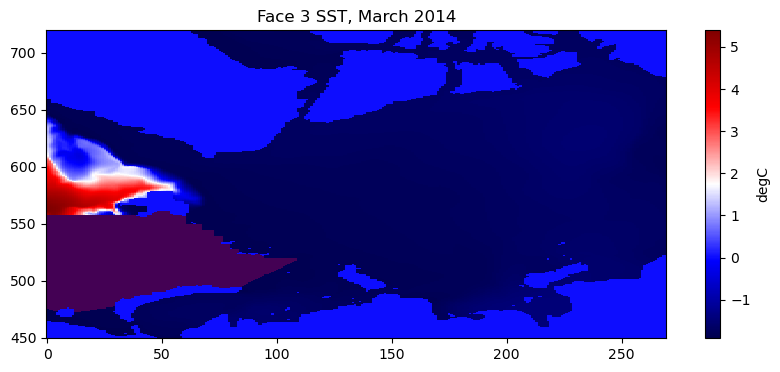

In [238]:
# pick a range of points at the surface and draw a box
# plot for face 3
XV,YV = np.meshgrid(np.arange(0,270,1),np.arange(450,720,1))
plt.pcolormesh(XV,YV,theta[0][450:720,:270],cmap='seismic')
plt.colorbar(label="degC")

plt.pcolormesh(XV,YV,mymsk[450:720,:270],cmap='viridis')

plt.title("Face 3 SST, March 2014")
# plt.savefig(path + "BarentsS_Sept2014_patch.png",dpi=300)

In [239]:
points = np.argwhere(mymsk == 1)
ys = points[:,0]
xs = points[:,1]
zs = np.zeros(xs.shape[0]).astype(int)

In [240]:
# for the surface distribution for one month
mesh_pt = np.zeros((nS, nT))

for k,i,j in zip(zs,ys,xs):
    iTpt = int(binned_theta[k,i,j])
    iSpt = int(binned_salinity[k,i,j])
    mesh_pt[iSpt,iTpt] += vol[0,k,i,j]  # m^3

mesh_pt = mesh_pt / binwidthsS_tile / binwidthsT_tile  # m^3/PSU/degC

In [241]:
# make this a for loop for points just to start
JtermsT = np.zeros((5,nS,nT))

# get the data (will be the same for all points)
aT = budgO['heatfluxes']['tend']
bT = budgO['heatfluxes']['ADV_Tconv']
cT = budgO['heatfluxes']['DF_Tconv']
dT = budgO['heatfluxes']['KPP_Tconv']
eT = zconv_top_heat.reshape(1,ny,nx)
fT = swtop

for k,i,j in zip(zs,ys,xs):
    iTpt = int(binned_theta[k,i,j])
    iSpt = int(binned_salinity[k,i,j])

    # select for the column - this is ultimately overkill for just the surface
    aa = np.zeros((nz, 1))
    n = 0
    aa[:, n] = (aT[:, i, j] - bT[:, i, j] - cT[:, i, j] - dT[:, i, j])
    aa[1:-1, n] += (fT[2:,i,j] - fT[1:-1,i,j])    # for swtop we want the difference between the top and bottom
    aa[0, n] += fT[1,i,j]
    aa[0, n] -= zconv_top_heat[i, j]      # subtract the TFLUX at the surface only

    # save the J terms for here for the single point   
    JtendT = (aT[0,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6             # Sv/PSU
    JADVT = (bT[0,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6              # Sv/PSU
    JDFT = (cT[0,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6               # Sv/PSU
    JKPPT = (dT[0,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6              # Sv/PSU
    JsurfT = (eT[0,i,j] - fT[1,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6 # Sv/PSU

    # set these in meshes so we can plot
    c = 0
    for valT in (np.array([JtendT,JADVT,JDFT,JKPPT,JsurfT])):
        #print(valT)
        JtermsT[c,iSpt,iTpt] = valT
        c += 1

print("total residual",np.nansum(JtermsT[0] - JtermsT[1] - JtermsT[2] - JtermsT[3] - JtermsT[4]),"Sv/PSU")

total residual 1.5095563687950175e-14 Sv/PSU


In [242]:
# initialize the J vectors for salt
JtermsS = np.zeros((5,nS,nT))

# get the values
aS = budgO['saltfluxes']['tend']
bS = budgO['saltfluxes']['ADV_Sconv']
cS = budgO['saltfluxes']['DF_Sconv']
dS = budgO['saltfluxes']['KPP_Sconv']
eS = zconv_top_salt.reshape(1,ny,nx)
fS = sptop

for k,i,j in zip(zs,ys,xs):
    iTpt = int(binned_theta[k,i,j])
    iSpt = int(binned_salinity[k,i,j])

    # do for one column - overkill but we can make it work here
    aa = np.zeros((nz, 1))
    n = 1
    ix, iy, k = pt[n-1]
    aa[:, n-1] = aS[:, i, j] - bS[:, i, j] - cS[:, i, j] - dS[:, i, j]
    aa[1:, n-1] += (fS[1:,i,j] - fS[:-1,i,j])                                  # from the oceSPflx and oceSPtnd
    aa[0, n-1] += fS[0,i,j]
    aa[0, n-1] -= zconv_top_salt[i, j]
    
    # save the J terms for here for the single point   
    JtendS = (aS[0,i,j]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6             # Sv/degC
    JADVS = (bS[0,i,j]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6              # Sv/degC
    JDFS = (cS[0,i,j]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6               # Sv/degC
    JKPPS = (dS[0,i,j]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6              # Sv/degC
    JsurfS= (eS[0,i,j] - fS[1,i,j]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6  # Sv/degC

    # set these in meshes so we can plot
    c = 0
    for valS in (np.array([JtendS,JADVS,JDFS,JKPPS,JsurfS])):
        #print(valT)
        JtermsS[c,iSpt,iTpt] = valS
        c += 1

# we will not print all terms here -- overkill
print("total residual",np.nansum(JtermsS[0] - JtermsS[1] - JtermsS[2] - JtermsS[3] - JtermsS[4]),"Sv/PSU")

total residual -9.318023112447724e-10 Sv/PSU


In [243]:
# plot these on a figure to show the budgeted terms
sfact = 8   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = 0
U = 1000
scale = 5e3

xlims = np.array([33,35.5])
ylims = np.array([-2,7])

# xlims = np.array([33.2,34.8])
# ylims = np.array([4,7.5])

# first get the values and do conversions to Sv/degC or Sv/PSU

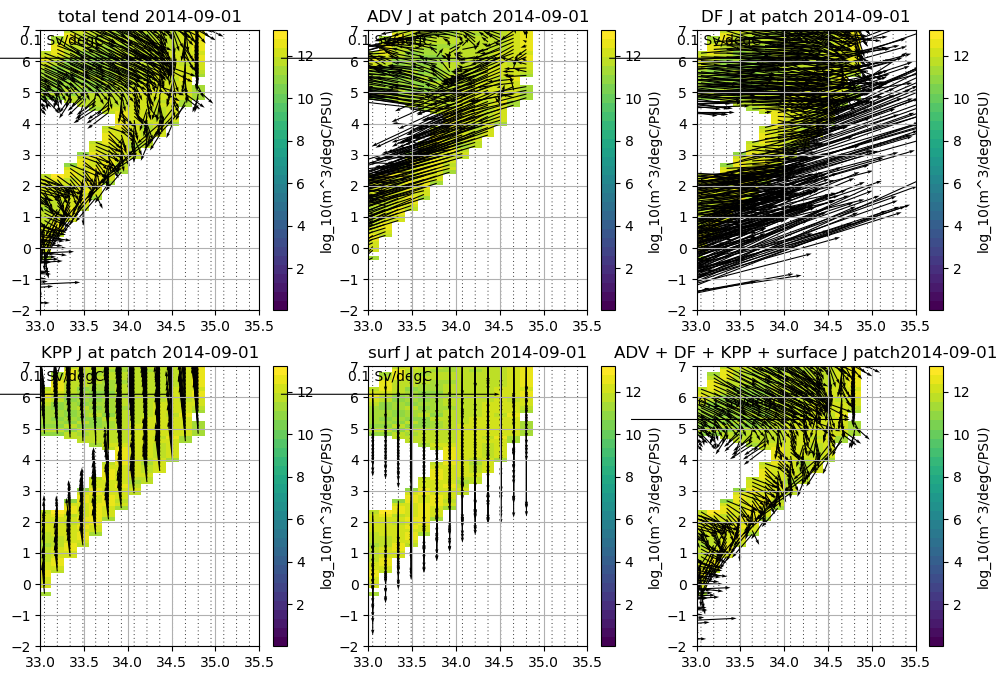

In [244]:
# plot these on a figure to show the budgeted terms
sfact = 8   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = 0
U = .1
scale = 1e-1


# first get the values and do conversions to Sv/degC or Sv/PSU
fig = plt.figure(figsize = (12,8))

# total tendency
ax = plt.subplot(231)
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
U1, V1 = JtermsS[0],JtermsT[0]/sfact
q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax.set_title("total tend " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()
ax.quiverkey(q1,X=0.1,Y=0.9,U = U,label=str(U) + " Sv/degC")

# ADV tendency
ax = plt.subplot(232)
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
U1, V1 = JtermsS[1],JtermsT[1]/sfact
q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax.set_title("ADV J at patch " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()
ax.quiverkey(q1,X=0.1,Y=0.9,U = U,label=str(U) + " Sv/degC")

# DF tendency
ax = plt.subplot(233)
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
U1, V1 = JtermsS[2],JtermsT[2]/sfact
q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax.set_title("DF J at patch " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()
ax.quiverkey(q1,X=0.1,Y=0.9,U = U,label=str(U) + " Sv/degC")

# KPP tendency
ax = plt.subplot(234)
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
U1, V1 = JtermsS[3],JtermsT[3]/sfact
q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax.set_title("KPP J at patch " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()
ax.quiverkey(q1,X=0.1,Y=0.9,U = U,label=str(U) + " Sv/degC")

# surface tendency
ax = plt.subplot(235)
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
U1, V1 = JtermsS[4],JtermsT[4]/sfact
q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax.set_title("surf J at patch " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()
ax.quiverkey(q1,X=0.1,Y=0.9,U = U,label=str(U) + " Sv/degC")

# for total tendency for this square from terms
ax = plt.subplot(236)
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(mesh_pt), cmap=cmap2, vmin=0.01)
U1, V1 = (JtermsS[1] + JtermsS[2] + JtermsS[3] + JtermsS[4]),(JtermsT[1] + JtermsT[2] + JtermsT[3] + JtermsT[4])/sfact
q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax.set_title("ADV + DF + KPP + surface J patch" + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()
ax.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC")

# save the figure for this point
# plt.savefig(path + "patchwork_march.png",dpi=300)

# now do for the whole water column

In [245]:
# plt.pcolormesh(get_aste_tracer(mygrid['hFacC']*mymsk,nfx,nfy)[30])
# plt.xlim(400,540)
# plt.ylim(400,600)
# plt.colorbar()

In [246]:
# make this a for loop for points just to start
JtermsT = np.zeros((5,nS,nT))

# get the data (will be the same for all points)
aT = budgO['heatfluxes']['tend']
bT = budgO['heatfluxes']['ADV_Tconv']
cT = budgO['heatfluxes']['DF_Tconv']
dT = budgO['heatfluxes']['KPP_Tconv']
eT = zconv_top_heat.reshape(1,ny,nx)
fT = swtop

for i,j in zip(ys,xs):

    # select for the column - this is ultimately overkill for just the surface
    # aa = np.zeros((nz, 1))
    # n = 0
    # aa[:, n] = (aT[:, i, j] - bT[:, i, j] - cT[:, i, j] - dT[:, i, j])
    # aa[1:-1, n] += (fT[2:,i,j] - fT[1:-1,i,j])    # for swtop we want the difference between the top and bottom
    # aa[0, n] += fT[1,i,j]
    # aa[0, n] -= zconv_top_heat[i, j]      # subtract the TFLUX at the surface only

    # loop through the z values and see if we can plot
    for k in range(nz-1):                 # stop at second to last level for 
        iTpt = int(binned_theta[k,i,j])
        iSpt = int(binned_salinity[k,i,j])

        # save the J terms for here for the single point   
        JtendT = (aT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6             # Sv/PSU
        JADVT = (bT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6              # Sv/PSU
        JDFT = (cT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6               # Sv/PSU
        JKPPT = (dT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6              # Sv/PSU

        if k == 0:
            JsurfT = (eT[k,i,j] - fT[k+1,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6 # Sv/PSU
        else:
            JsurfT = -(fT[k+1,i,j] - fT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6 # Sv/PSU

        # set these in meshes so we can plot
        c = 0
        for valT in (np.array([JtendT,JADVT,JDFT,JKPPT,JsurfT])):
            #print(valT)
            JtermsT[c,iSpt,iTpt] += valT
            c += 1

    # for each Jterm fill the 0 values with nan before we plot
    #for c in range(5):
    #    tmp = JtermsT[c]
    #    tmp[tmp == 0] = np.nan
    #    JtermsT[c] = tmp

print("total residual",np.nansum(JtermsT[0] - JtermsT[1] - JtermsT[2] - JtermsT[3] - JtermsT[4]),"Sv/PSU")

total residual -1.6975699300509554e-12 Sv/PSU


In [247]:
# initialize the J vectors for salt
JtermsS = np.zeros((5,nS,nT))

# get the values
aS = budgO['saltfluxes']['tend']
bS = budgO['saltfluxes']['ADV_Sconv']
cS = budgO['saltfluxes']['DF_Sconv']
dS = budgO['saltfluxes']['KPP_Sconv']
eS = zconv_top_salt.reshape(1,ny,nx)
fS = sptop

for i,j in zip(ys,xs):

    # do for one column - overkill but we can make it work here
    # aa = np.zeros((nz, 1))
    # n = 1
    # ix, iy, k = pt[n-1]
    # aa[:, n-1] = aS[:, i, j] - bS[:, i, j] - cS[:, i, j] - dS[:, i, j]
    # aa[1:, n-1] += (fS[1:,i,j] - fS[:-1,i,j])                                  # from the oceSPflx and oceSPtnd
    # aa[0, n-1] += fS[0,i,j]
    # aa[0, n-1] -= zconv_top_salt[i, j]

    # loop through the depths and add
    for k in range (nz-1):
        iTpt = int(binned_theta[k,i,j])
        iSpt = int(binned_salinity[k,i,j])
    
        # save the J terms for here for the single point   
        JtendS = (aS[k,i,j]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6             # Sv/degC
        JADVS = (bS[k,i,j]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6              # Sv/degC
        JDFS = (cS[k,i,j]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6               # Sv/degC
        JKPPS = (dS[k,i,j]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6              # Sv/degC

        # surface term will be unique
        if k == 0:
            JsurfS = (eS[k,i,j] - fS[k+1,i,j]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6  # Sv/degC
        else:
            JsurfS = -(fS[k,i,j] - fS[k-1,i,j]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6  # Sv/degC

        # set these in meshes so we can plot
        c = 0
        for valS in (np.array([JtendS,JADVS,JDFS,JKPPS,JsurfS])):
            #print(valT)
            JtermsS[c,iSpt,iTpt] += valS
            c += 1

    # for each Jterm fill the 0 values with nan before we plot
    #for c in range(5):
    #    tmp = JtermsS[c]
    #    tmp[tmp == 0] = np.nan
    #    JtermsS[c] = tmp

# we will not print all terms here -- overkill
print("total residual",np.nansum(JtermsS[0] - JtermsS[1] - JtermsS[2] - JtermsS[3] - JtermsS[4]),"Sv/PSU")

total residual -2.4478688304281134e-06 Sv/PSU


In [248]:
# add the isopycnals
# add the density contours from gsw
smin = 25.5 - (0.01 * 25.5)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38 + (0.01 * 38)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2 + (0.1 * -2)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 31 + (0.1 * 31)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 50
ydim = 50
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2,31,ydim)
si = np.linspace(25.5,38,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

tmin, tmax, smin, smax sizes=, -2.2 34.1 25.245 38.38


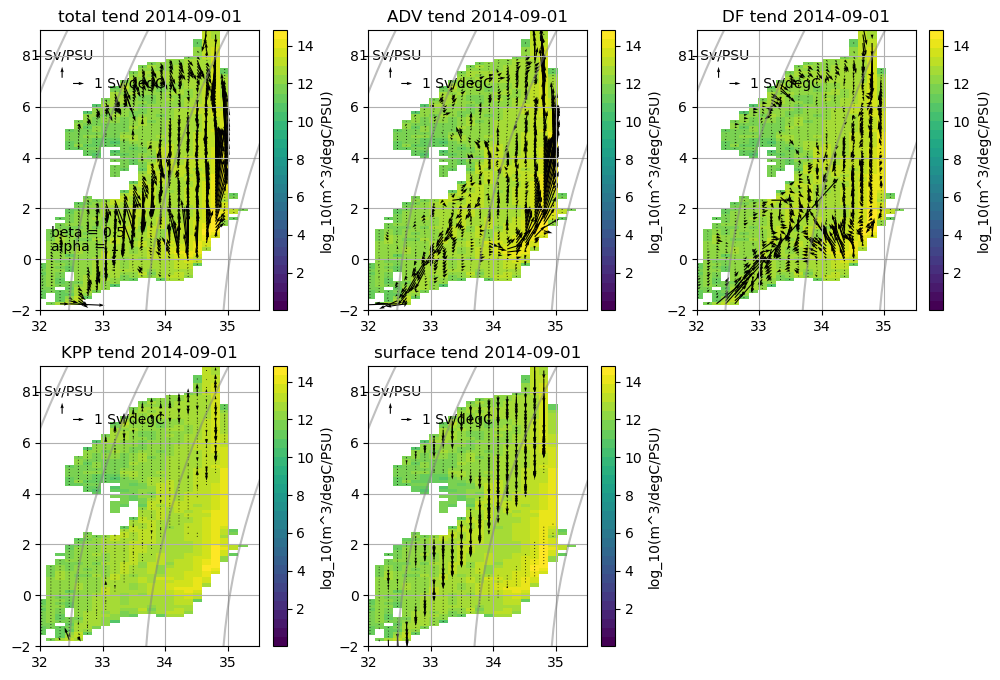

In [253]:
# plot these on a figure to show the budgeted terms
alpha = 1
beta = .5
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = 0
U = 1
scale = 2e1

xlims = np.array([32,35.5])
ylims = np.array([-2,9])


# first get the values and do conversions to Sv/degC or Sv/PSU
fig = plt.figure(figsize = (12,8))

# total tendency
ax = plt.subplot(231)
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
# Set U1 and V1 and apply alpha and beta scaling
U1, V1 = JtermsS[0], JtermsT[0]
# U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
U1, V1 = U1 * alpha, V1 * beta
# Plot quiver
q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005, scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
# Set title, limits, and grid
ax.set_title("total tend " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()
# Add the quiver key for Sv/PSU
# Adjust X and Y to position the quiver key appropriately on the plot
quiver_length = 1.0  # Set the length of the arrow for the key
ax.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC",labelpos='E')
ax.quiverkey(q1, X=0.1, Y=0.85, U=U, label=str(U) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
# Add alpha and beta text to the plot
ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")


# ADV tendency
ax = plt.subplot(232)
U1, V1 = JtermsS[1],JtermsT[1]
# U1[U1 == 0],V1[V1 == 0] = np.nan,np.nan
U1, V1 = U1*alpha,V1*beta
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
# Plot quiver
q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005, scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
# Set title, limits, and grid
ax.set_title("ADV tend " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()
# Add the quiver key for Sv/PSU
# Adjust X and Y to position the quiver key appropriately on the plot
quiver_length = 1.0  # Set the length of the arrow for the key
ax.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC",labelpos='E')
ax.quiverkey(q1, X=0.1, Y=0.85, U=U, label=str(U) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
# Add alpha and beta text to the plot
# ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# DF tendency
ax = plt.subplot(233)
U1, V1 = JtermsS[2],JtermsT[2]
# U1[U1 == 0],V1[V1 == 0] = np.nan,np.nan
U1, V1 = U1*alpha,V1*beta
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
# Plot quiver
q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005, scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
# Set title, limits, and grid
ax.set_title("DF tend " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()
# Add the quiver key for Sv/PSU
# Adjust X and Y to position the quiver key appropriately on the plot
quiver_length = 1.0  # Set the length of the arrow for the key
ax.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC",labelpos='E')
ax.quiverkey(q1, X=0.1, Y=0.85, U=U, label=str(U) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
# Add alpha and beta text to the plot
# ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# KPP tendency
ax = plt.subplot(234)
U1, V1 = JtermsS[3],JtermsT[3]
# U1[U1 == 0],V1[V1 == 0] = np.nan,np.nan
U1, V1 = U1*alpha,V1*beta
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
# Plot quiver
q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005, scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
# Set title, limits, and grid
ax.set_title("KPP tend " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()
# Add the quiver key for Sv/PSU
# Adjust X and Y to position the quiver key appropriately on the plot
quiver_length = 1.0  # Set the length of the arrow for the key
ax.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC",labelpos='E')
ax.quiverkey(q1, X=0.1, Y=0.85, U=U, label=str(U) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
# Add alpha and beta text to the plot
# ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# surface tendency
ax = plt.subplot(235)
U1, V1 = JtermsS[4],JtermsT[4]
# U1[U1 == 0],V1[V1 == 0] = np.nan,np.nan
U1, V1 = U1*alpha,V1*beta
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
# Plot quiver
q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005, scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
# Set title, limits, and grid
ax.set_title("surface tend " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()
# Add the quiver key for Sv/PSU
# Adjust X and Y to position the quiver key appropriately on the plot
quiver_length = 1.0  # Set the length of the arrow for the key
ax.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC",labelpos='E')
ax.quiverkey(q1, X=0.1, Y=0.85, U=U, label=str(U) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
# Add alpha and beta text to the plot
# ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# for total tendency for this square from terms
# ax = plt.subplot(236)
# U1, V1 = (JtermsS[1] + JtermsS[2] + JtermsS[3] + JtermsS[4]),(JtermsT[1] + JtermsT[2] + JtermsT[3] + JtermsT[4])
# # U1[U1 == 0],V1[V1 == 0] = np.nan,np.nan
# U1, V1 = U1*alpha,V1*beta
# cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
# # Plot quiver
# q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005, scale=scale)
# plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
# # Set title, limits, and grid
# ax.set_title("total tend " + datetimes[0].strftime("%Y-%m-%d"))
# ax.set_xlim(xlims)
# ax.set_ylim(ylims)
# ax.grid()
# # Add the quiver key for Sv/PSU
# # Adjust X and Y to position the quiver key appropriately on the plot
# quiver_length = 1.0  # Set the length of the arrow for the key
# ax.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC",labelpos='E')
# ax.quiverkey(q1, X=0.1, Y=0.85, U=U, label=str(U) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
# # Add alpha and beta text to the plot
# # ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# # ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# # Add density contours
# cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
# cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# save the figure for this point
plt.savefig(path + "BarentsS_alltend_Sept2014.png",dpi=300)

# add the divergence of terms
We want this in Sverdrups, so we need to leave the J terms in terms of Sv


In [254]:
# make this a for loop for points just to start
JtermsT = np.zeros((5,nS,nT))

# get the data (will be the same for all points)
aT = budgO['heatfluxes']['tend']
bT = budgO['heatfluxes']['ADV_Tconv']
cT = budgO['heatfluxes']['DF_Tconv']
dT = budgO['heatfluxes']['KPP_Tconv']
eT = zconv_top_heat.reshape(1,ny,nx)
fT = swtop

for i,j in zip(ys,xs):

    # loop through the z values and see if we can plot
    for k in range(nz-1):                 # stop at second to last level for 
        iTpt = int(binned_theta[k,i,j])
        iSpt = int(binned_salinity[k,i,j])

        # save the J terms for here for the single point   
        JtendT = (aT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] * 1e-6             # Sv
        JADVT = (bT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] * 1e-6              # Sv
        JDFT = (cT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] * 1e-6               # Sv
        JKPPT = (dT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] * 1e-6              # Sv

        if k == 0:
            JsurfT = (eT[k,i,j] - fT[k+1,i,j]) / myparms['rcp'] / binwidthT[iTpt] * 1e-6 # Sv
        else:
            JsurfT = -(fT[k+1,i,j] - fT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] * 1e-6 # Sv

        # set these in meshes so we can plot
        c = 0
        for valT in (np.array([JtendT,JADVT,JDFT,JKPPT,JsurfT])):
            #print(valT)
            JtermsT[c,iSpt,iTpt] += valT
            c += 1

print("total residual",np.nansum(JtermsT[0] - JtermsT[1] - JtermsT[2] - JtermsT[3] - JtermsT[4]),"Sv")

total residual -2.475768882489489e-13 Sv


In [255]:
# initialize the J vectors for salt
JtermsS = np.zeros((5,nS,nT))

# get the values
aS = budgO['saltfluxes']['tend']
bS = budgO['saltfluxes']['ADV_Sconv']
cS = budgO['saltfluxes']['DF_Sconv']
dS = budgO['saltfluxes']['KPP_Sconv']
eS = zconv_top_salt.reshape(1,ny,nx)
fS = sptop

for i,j in zip(ys,xs):

    # loop through the depths and add
    for k in range (nz-1):
        iTpt = int(binned_theta[k,i,j])
        iSpt = int(binned_salinity[k,i,j])
    
        # save the J terms for here for the single point   
        JtendS = (aS[k,i,j]) / myparms['rhoconst'] / binwidthS[iSpt] * 1e-6             # Sv
        JADVS = (bS[k,i,j]) / myparms['rhoconst'] / binwidthS[iSpt] * 1e-6              # Sv
        JDFS = (cS[k,i,j]) / myparms['rhoconst'] / binwidthS[iSpt] * 1e-6               # Sv
        JKPPS = (dS[k,i,j]) / myparms['rhoconst'] / binwidthS[iSpt] * 1e-6              # Sv

        # surface term will be unique
        if k == 0:
            JsurfS = (eS[k,i,j] - fS[k+1,i,j]) / myparms['rhoconst'] / binwidthS[iSpt] * 1e-6  # Sv
        else:
            JsurfS = -(fS[k,i,j] - fS[k-1,i,j]) / myparms['rhoconst'] / binwidthS[iSpt] * 1e-6  # Sv

        # set these in meshes so we can plot
        c = 0
        for valS in (np.array([JtendS,JADVS,JDFS,JKPPS,JsurfS])):
            #print(valT)
            JtermsS[c,iSpt,iTpt] += valS
            c += 1

# we will not print all terms here -- overkill
print("total residual",np.nansum(JtermsS[0] - JtermsS[1] - JtermsS[2] - JtermsS[3] - JtermsS[4]),"Sv")

total residual -2.926810040725578e-07 Sv


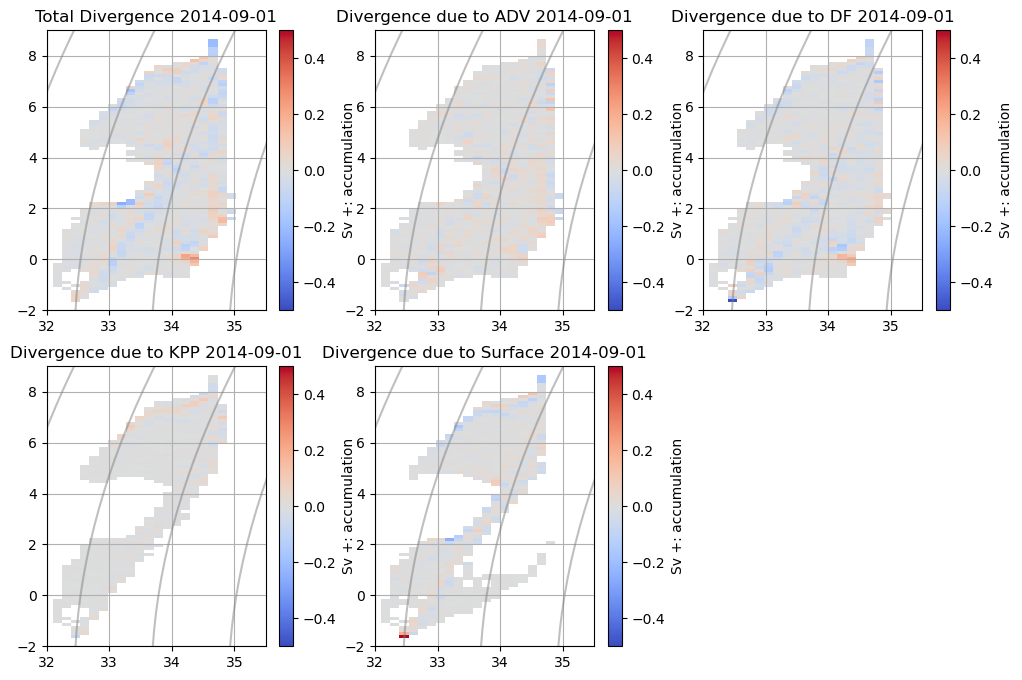

In [256]:
# Calculate the divergence of the vector field (U1, V1)
# Assuming Sbincent and Tbincent are the grid coordinates


# First, set up the plot
fig = plt.figure(figsize=(12, 8))

# Total tendency
ax = plt.subplot(231)
U1, V1 = JtermsS[0], JtermsT[0]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
U1, V1 = U1 * alpha, V1 * beta
divergence = np.gradient(U1, axis=0) + np.gradient(V1, axis=1)

# Plot pcolormesh using the divergence for coloring
# Normalize the divergence values for color mapping

# Use pcolormesh to color the background by divergence
cb1 = ax.pcolormesh(Sbin, Tbin, divergence, cmap='coolwarm', vmin=-.5,vmax=.5)
plt.colorbar(cb1, ax=ax, label="Sv +: accumulation")

# Set U1 and V1 and apply alpha and beta scaling
U1, V1 = JtermsS[0], JtermsT[0]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
U1, V1 = U1 * alpha, V1 * beta

# Plot the quiver on top of the divergence background
#q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005, scale=scale)

# Set title, limits, and grid
ax.set_title("Total Divergence " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()

# Add the quiver keys for Sv/degC and Sv/PSU
#quiver_length = 1.0  # Set the length of the arrow for the key
#ax.quiverkey(q1, X=0.2, Y=0.81, U=U, label=str(U) + " Sv/degC", labelpos='E')
#ax.quiverkey(q1, X=0.1, Y=0.85, U=U, label=str(U) + " Sv/PSU", angle=90, labelpos='N', coordinates='axes')

# Add alpha and beta text to the plot
#ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
#ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')

# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

####################################################################################

# advection plot
ax = plt.subplot(232)
U1, V1 = JtermsS[1], JtermsT[1]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
U1, V1 = U1 * alpha, V1 * beta
divergence = np.gradient(U1, axis=0) + np.gradient(V1, axis=1)

# Plot pcolormesh using the divergence for coloring
# Normalize the divergence values for color mapping

# Use pcolormesh to color the background by divergence
cb1 = ax.pcolormesh(Sbin, Tbin, divergence, cmap='coolwarm', vmin=-.5,vmax=.5)
plt.colorbar(cb1, ax=ax, label="Sv +: accumulation")

# Set U1 and V1 and apply alpha and beta scaling
U1, V1 = JtermsS[0], JtermsT[0]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
U1, V1 = U1 * alpha, V1 * beta

# Plot the quiver on top of the divergence background
#q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005, scale=scale)

# Set title, limits, and grid
ax.set_title("Divergence due to ADV " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()

# Add the quiver keys for Sv/degC and Sv/PSU
#quiver_length = 1.0  # Set the length of the arrow for the key
#ax.quiverkey(q1, X=0.2, Y=0.81, U=U, label=str(U) + " Sv/degC", labelpos='E')
#ax.quiverkey(q1, X=0.1, Y=0.85, U=U, label=str(U) + " Sv/PSU", angle=90, labelpos='N', coordinates='axes')

# Add alpha and beta text to the plot
#ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
#ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')

# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

####################################################################################
# diffusion plot
ax = plt.subplot(233)
U1, V1 = JtermsS[2], JtermsT[2]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
U1, V1 = U1 * alpha, V1 * beta
divergence = np.gradient(U1, axis=0) + np.gradient(V1, axis=1)

# Plot pcolormesh using the divergence for coloring
# Normalize the divergence values for color mapping

# Use pcolormesh to color the background by divergence
cb1 = ax.pcolormesh(Sbin, Tbin, divergence, cmap='coolwarm', vmin=-.5,vmax=.5)
plt.colorbar(cb1, ax=ax, label="Sv +: accumulation")

# Set U1 and V1 and apply alpha and beta scaling
U1, V1 = JtermsS[0], JtermsT[0]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
U1, V1 = U1 * alpha, V1 * beta

# Plot the quiver on top of the divergence background
#q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005, scale=scale)

# Set title, limits, and grid
ax.set_title("Divergence due to DF " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()

# Add the quiver keys for Sv/degC and Sv/PSU
#quiver_length = 1.0  # Set the length of the arrow for the key
#ax.quiverkey(q1, X=0.2, Y=0.81, U=U, label=str(U) + " Sv/degC", labelpos='E')
#ax.quiverkey(q1, X=0.1, Y=0.85, U=U, label=str(U) + " Sv/PSU", angle=90, labelpos='N', coordinates='axes')

# Add alpha and beta text to the plot
#ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
#ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')

# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

####################################################################################
# KPP plot
ax = plt.subplot(234)
U1, V1 = JtermsS[3], JtermsT[3]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
U1, V1 = U1 * alpha, V1 * beta
divergence = np.gradient(U1, axis=0) + np.gradient(V1, axis=1)

# Plot pcolormesh using the divergence for coloring
# Normalize the divergence values for color mapping

# Use pcolormesh to color the background by divergence
cb1 = ax.pcolormesh(Sbin, Tbin, divergence, cmap='coolwarm', vmin=-.5,vmax=.5)
plt.colorbar(cb1, ax=ax, label="Sv +: accumulation")

# Set U1 and V1 and apply alpha and beta scaling
U1, V1 = JtermsS[0], JtermsT[0]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
U1, V1 = U1 * alpha, V1 * beta

# Plot the quiver on top of the divergence background
#q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005, scale=scale)

# Set title, limits, and grid
ax.set_title("Divergence due to KPP " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()

# Add the quiver keys for Sv/degC and Sv/PSU
#quiver_length = 1.0  # Set the length of the arrow for the key
#ax.quiverkey(q1, X=0.2, Y=0.81, U=U, label=str(U) + " Sv/degC", labelpos='E')
#ax.quiverkey(q1, X=0.1, Y=0.85, U=U, label=str(U) + " Sv/PSU", angle=90, labelpos='N', coordinates='axes')

# Add alpha and beta text to the plot
#ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
#ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')

# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

####################################################################################
# surface plot
ax = plt.subplot(235)
U1, V1 = JtermsS[4], JtermsT[4]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
U1, V1 = U1 * alpha, V1 * beta
divergence = np.gradient(U1, axis=0) + np.gradient(V1, axis=1)

# Plot pcolormesh using the divergence for coloring
# Normalize the divergence values for color mapping

# Use pcolormesh to color the background by divergence
cb1 = ax.pcolormesh(Sbin, Tbin, divergence, cmap='coolwarm', vmin=-.5,vmax=.5)
plt.colorbar(cb1, ax=ax, label="Sv +: accumulation")

# Set U1 and V1 and apply alpha and beta scaling
U1, V1 = JtermsS[0], JtermsT[0]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
U1, V1 = U1 * alpha, V1 * beta

# Plot the quiver on top of the divergence background
#q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005, scale=scale)

# Set title, limits, and grid
ax.set_title("Divergence due to Surface " + datetimes[0].strftime("%Y-%m-%d"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()

# Add the quiver keys for Sv/degC and Sv/PSU
#quiver_length = 1.0  # Set the length of the arrow for the key
#ax.quiverkey(q1, X=0.2, Y=0.81, U=U, label=str(U) + " Sv/degC", labelpos='E')
#ax.quiverkey(q1, X=0.1, Y=0.85, U=U, label=str(U) + " Sv/PSU", angle=90, labelpos='N', coordinates='axes')

# Add alpha and beta text to the plot
#ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
#ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')

# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

plt.savefig(path + "divergence_Barents_Sept2014.png",dpi=300)

# break down the surface J into parts